In [2]:
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from skimage import io
import fs
import torchvision
from torchvision import transforms
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
cuda = torch.cuda.is_available()
import time
device = torch.device("cuda" if cuda else "cpu")
from mlxtend.data import loadlocal_mnist

In [3]:
from torch.utils.data import Dataset, DataLoader

class DrivingDataset(Dataset):
    def __init__(self,data_dir, input_w=224, input_h=224,is_train=True,transform=None):
        if is_train==False:
            threshold=51#use 50 from each class as validation
        else:
            threshold=300#300 as training
        namelist = [[] for i in range(15)]
        
        self.data_filenames = []
        self.data_ids = []
        self.is_train=is_train

        self.data_root=fs.open_fs(data_dir)
        self.transform = transform
        for p in self.data_root.walk.files(filter=["*.jpg","*.png"]):
            filename=data_dir+p
            if is_train==True:#temporary bug
                if "zero"  in filename:
                    if len(namelist[0])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(0)
                        namelist[0].append(1)
                elif "one" in filename:
                    if len(namelist[1])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(1)
                        namelist[1].append(1)
                elif "two" in filename:
                    if len(namelist[2])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(2)
                        namelist[2].append(1)
                elif "three" in filename:
                    if len(namelist[3])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(3)
                        namelist[3].append(1)
                elif "four" in filename:
                    if len(namelist[4])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(4)
                        namelist[4].append(1)
                elif "five" in filename:
                    if len(namelist[5])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(5)
                        namelist[5].append(1)
                elif "six" in filename:
                    if len(namelist[6])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(6)
                        namelist[6].append(1)
                elif "seven" in filename:
                    if len(namelist[7])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(7)
                        namelist[7].append(1)
                elif "eight" in filename:
                    if len(namelist[8])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(8)
                        namelist[8].append(1)
                elif "nine" in filename:
                    if len(namelist[9])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(9)
                        namelist[9].append(1)
                elif "plus" in filename:
                    if len(namelist[10])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(10)
                        namelist[10].append(1)
                elif "minus" in filename:
                    if len(namelist[11])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(11)
                        namelist[11].append(1)

                elif "times" in filename:
                    if len(namelist[12])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(12)
                        namelist[12].append(1)
                elif "div" in filename:
                    if len(namelist[13])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(13)
                        namelist[13].append(1)
                elif "equal" in filename:
                    if len(namelist[14])<threshold:
                        self.data_filenames.append(filename)
                        self.data_ids.append(14)
                        namelist[14].append(1)
            else:
                self.data_filenames.append(filename)
                self.data_ids.append(0)
        
        
        # print(self.data_filenames)
        #print(self.data_ids)
        print(len(self.data_ids))

        #self.input_w = input_w
        #self.input_h = input_h

    def __getitem__(self, item):
        """Grey(i, j) = 0.299 × R(i, j) + 0.587 × G(i, j) + 0.114 × B(i, j)"""

        img_path = self.data_filenames[item]
        #print(img_path)
        target = self.data_ids[item]

        image = cv2.imread(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        target = np.array([target], dtype=np.long)
        target = torch.from_numpy(target)
        
        return image,target

    def __len__(self):
        return len(self.data_filenames)
    

In [4]:
#新的transform，通过padding保证不畸变图片,ratio是需要设置的最终图片长宽比
class ratio_crop(object):
    def __init__(self, ratio=1.0):
        self.ratio = ratio
    def __call__(self, images):
            ratio=1.0
            #for img in images:
            #print(images.shape)
            w=images.shape[1]
            h=images.shape[0]
            aspect_ratio=float(w)/float(h)
            #print(images.shape,aspect_ratio)
            if aspect_ratio==ratio:
                a=1
            elif aspect_ratio>ratio:
                dif = np.abs(w  - h)
                pad1, pad2 = int(dif // 2), int(dif - dif // 2)
                pad = ((0, 0),(pad1, pad2) ,(0, 0))
                images = np.pad(images, pad, "constant", constant_values=255)
                #input_img = cv2.resize(input_x, (inputwidth, inputheight))
            else:
                # padding w
                dif = np.abs(h  - w)
                pad1, pad2 = int(dif // 2), int(dif - dif // 2)
                pad = ((0, 0),(pad1, pad2),(0, 0))
                images = np.pad(images, pad, "constant", constant_values=255)
                #input_img = cv2.resize(input_x, (inputwidth, inputheight))
            return images
        
transform = transforms.Compose([
            ratio_crop(1.0),
            transforms.ToPILImage(),
            transforms.Resize((28,28), interpolation=2),
            transforms.Pad(5, fill=255, padding_mode='constant'),
            #transforms.RandomResizedCrop(56, scale=(0.7, 1.0)),
            transforms.Resize((56,56), interpolation=2),
            
            #transforms.RandomHorizontalFlip(0.2), 
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]) 

In [6]:
path='C:/Users/zhaoh/Downloads/FYP/UI/master/sliced/'
for f in os.listdir(path):
    name=os.path.join(path+str(f))
    if "jpg" in name:
        im = cv2.imread(name)
        if im.all()!=0:
            os.remove(name)

In [7]:
data_dir=path
#train_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/train/", is_train=True,transform=transform) 
#val_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/test/", is_train=False,transform=transform) 
test_set = DrivingDataset(path,is_train=False, transform=transform) 


5


In [9]:
batch_size = 50
#n_workers = multiprocessing.cpu_count()

testloader = torch.utils.data.DataLoader(test_set, batch_size=50,
                                          shuffle=False, num_workers=0)


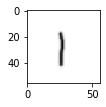

IndexError: index 5 is out of bounds for dimension 0 with size 5

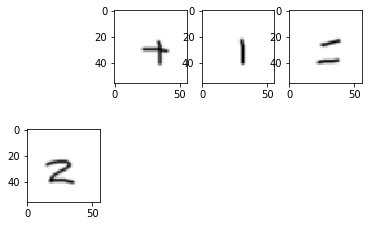

In [10]:
#take a look of training set
image_batch,label= next(iter(testloader))
for i in range(20): 
    img = (image_batch[i].numpy())
    plt.subplot(2,4,(i%8+1))
    plt.imshow(img[0],cmap = "gray")
    if i%8==0:
        plt.show()
    
print(img.shape)


In [11]:
#define the network below
####################################
#######################################
###########################################
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url 


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)###########################3 input channels
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model





def resnet152(pretrained=True, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    
    return model




In [19]:
import torch.optim as optim
model = torch.load('C:/Users/zhaoh/Downloads/FYP/modelnopad1.pkl')
criterion = nn.CrossEntropyLoss()
criterion_hinge=nn.MultiMarginLoss()
learning_rate = 1e-4
print(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

EOFError: Ran out of input

In [ ]:
#features = model.conv1.in_channels

#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [12]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        #Predicted=[]
        for data, target in (test_loader):
            
            data = data.float().to(device)
            #print(data.shape)
            target=target.squeeze(1)
            target = target.long().to(device)
            
            outputs = model(data)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted.shape)
            #Predicted.append(predicted)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            loss+=criterion_hinge(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [ ]:
#"C:/Users/zhaoh/Downloads/FYP/deeplearning new/new-number-identification/crop/"
#"C:/Users/zhaoh/Downloads/FYP/dataset/test/"
'''path='C:/Users/zhaoh/Downloads/FYP/dataset/test/'
i=0
for f in os.listdir(path):
    name=os.path.join(path+str(f))
    if "jpg" in name:
        im = cv2.imread(name)
        i+=1
        flip = 255-im
        cv2.imwrite(name,flip)
print(i)
'''
#test_set = DrivingDataset(data_dir="C:/Users/zhaoh/Downloads/FYP/dataset/test/", is_train=False,transform=transform)
#testloader = torch.utils.data.DataLoader(test_set, batch_size=5,
                                          #shuffle=True, num_workers=0)
for i,j in testloader:
    #i=255-i
    print(i.shape)
    for k in range(4):
        img = np.moveaxis(i[k].numpy(),0,2)
        #print(img.shape)
        plt.imshow(img[:,:,0],cmap='gray')
        plt.show()
    i=i.reshape(-1,3,56,56)
    outputs = model(i.to(device))
    _, predicted = torch.max(outputs.data, 1)
    #outputs = model(cell0.to(device))
    #_, predicted = torch.max(outputs.data, 1)
    #plt.show()
    print("prediction",predicted)